Data taken from the Blood Transfusion Service Center in Hsin-Chu City in Taiwan 

https://archive.ics.uci.edu/ml/datasets/Blood+Transfusion+Service+Center

Plan

EDA

BUILD
- Decide how do we want to evaluate our results --> accuracy, logloss, roc_auc
- Try to build a flexible combined pipeline for both text and numerical data

MODEL SELECTION
- Try models you have learned about
    * Logistic Regression
    * Knn
    * Bagging and random forest
    * Adaboost, Gradient boost, Stochastic gradient boosting

MODEL TUNING
- Select 2-3 best ones and proceed with hyperparamter tuning for each

EVALUATE RESULTS
- Summarize tradeoffs and implications of the models
- Why does it suit our data? What to be aware in the future if we are still going to use this model with new data

EXPLAIN
- Write a nice notebook and tell a story!

# EDA

In [222]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [223]:
# read csv and rename columns
df = pd.read_csv('transfusion.data', skiprows= 1, names=["Time since last donation (months)",
                                            "Donation count (times)",
                                            "Volume donated (cc)",
                                            "Time since first donation (months)",
                                            "Donated on March 2007"])
df.head()

,Time since last donation (months),Donation count (times),Volume donated (cc),Time since first donation (months),Donated on March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


## Features
- "Time since last donation (months)"
- "Donation count (times)",
- "Volume donated (cc)",
- "Time since first donation (months)"

## Target variable
- "Donated on March 2007"

In [224]:
df.info()
# no nulls very nice

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Time since last donation (months)   748 non-null    int64
 1   Donation count (times)              748 non-null    int64
 2   Volume donated (cc)                 748 non-null    int64
 3   Time since first donation (months)  748 non-null    int64
 4   Donated on March 2007               748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


In [225]:
# separate features and target
FEATURES = ["Time since last donation (months)",
            "Donation count (times)",
            "Volume donated (cc)",
            "Time since first donation (months)"]
X = df[FEATURES]

# convert outcome to category
# df["Donated on March 2007"] = df["Donated on March 2007"].astype('category')
y= df["Donated on March 2007"]

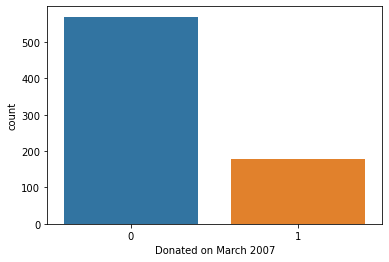

In [226]:
# look at total outcome
sns.countplot(data=df, x=df["Donated on March 2007"])
plt.show()

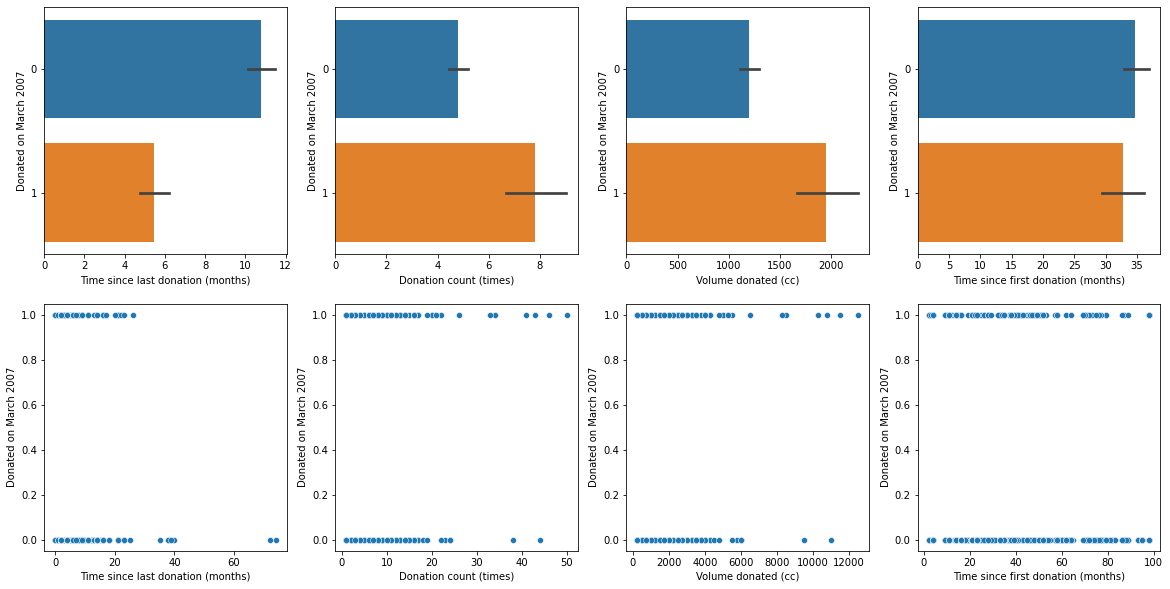

In [227]:
# look at the outcome for each feature
fig, ax = plt.subplots(2,4, figsize=(20,10))
for i in range(len(FEATURES)):
    sns.barplot(ax=ax[0][i], x=df[FEATURES[i]], y=df["Donated on March 2007"].astype('category'))
    sns.scatterplot(ax=ax[1][i], data=df, x=FEATURES[i], y="Donated on March 2007")
plt.show()

Time since last donation (months)
[<AxesSubplot:> <AxesSubplot:>]


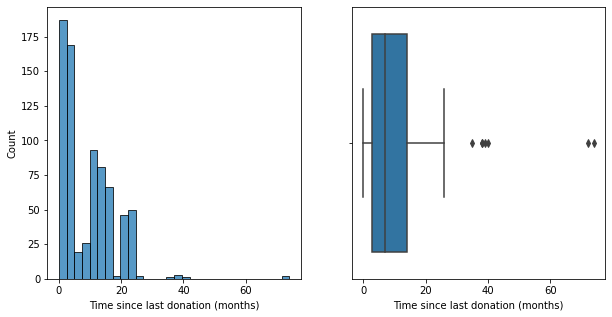

Donation count (times)
[<AxesSubplot:> <AxesSubplot:>]


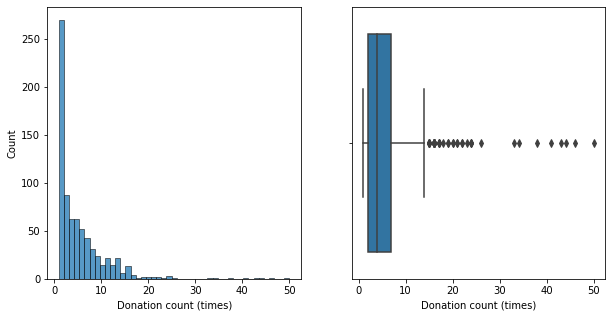

Volume donated (cc)
[<AxesSubplot:> <AxesSubplot:>]


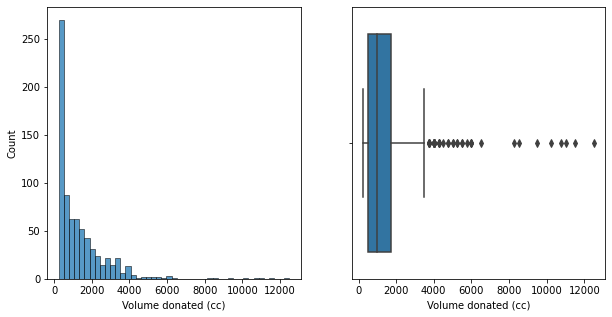

Time since first donation (months)
[<AxesSubplot:> <AxesSubplot:>]


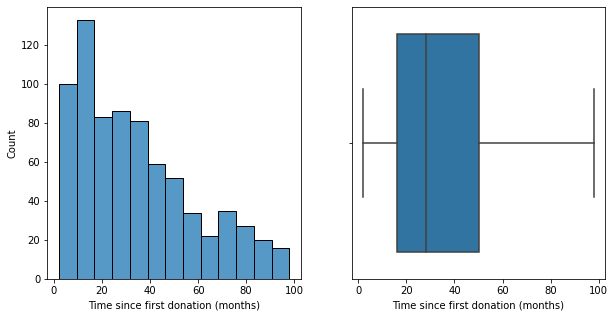

In [228]:
# look at the distributions of features
for f in FEATURES:
    print(f)
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    print(ax)
    sns.histplot(x=X[f], ax=ax[0])
    sns.boxplot(x=X[f], ax=ax[1])
    plt.show()

# features' scales are different we need to scale them
# features are rougly exponentially distributed

# Build

In [229]:
# split train test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=69)

# look at target ratios
print(y_train.sum()/len(y_train))
print(y_test.sum()/len(y_test))

0.24071322436849926
0.21333333333333335


In [230]:
# sklearn imports

# preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

# classifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

# pipeline
from sklearn.pipeline import make_pipeline

# metrics
from sklearn.metrics import accuracy_score, log_loss, classification_report

In [239]:
# construct pipelines
scalers = [StandardScaler(), MinMaxScaler(), Normalizer()]
clfs = [LogisticRegression(), 
                KNeighborsClassifier(),
                RandomForestClassifier(random_state=69),
                GradientBoostingClassifier(random_state=69)
                ]
pls = []
y_preds = []
y_pred_probas = []

for clf in clfs:
    # base model
    pl = make_pipeline(
                        clf
                        )
    # fit model
    pl.fit(X_train, y_train)
    pls.append(pl)
    # predict
    y_preds.append(pl.predict(X_test))
    y_pred_probas.append(pl.predict_proba(X_test))
    # with scaler
    for scaler in scalers:
        pl = make_pipeline(
                            scaler,
                            clf
                            )
        # fit model
        pl.fit(X_train, y_train)
        pls.append(pl)
        # predict
        y_preds.append(pl.predict(X_test))
        y_pred_probas.append(pl.predict_proba(X_test))

# look at result metrics
# for i in range(len(pls)):
#     print(pls[i])
#     print('Accuracy = {}, Logloss = {}'.format(accuracy_score(y_test, y_preds[i]), log_loss(y_test, y_pred_probas[i])))
#     print()

Pipeline(steps=[('logisticregression', LogisticRegression())])
Accuracy = 0.8, Logloss = 0.46974300096186394

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])
Accuracy = 0.8, Logloss = 0.4687993525725392

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression', LogisticRegression())])
Accuracy = 0.8133333333333334, Logloss = 0.470040873511671

Pipeline(steps=[('normalizer', Normalizer()),
                ('logisticregression', LogisticRegression())])
Accuracy = 0.7866666666666666, Logloss = 0.5117820934810059

Pipeline(steps=[('kneighborsclassifier', KNeighborsClassifier())])
Accuracy = 0.76, Logloss = 1.3488236966550662

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])
Accuracy = 0.76, Logloss = 1.7501413272925808

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])
Accuracy = 0.76, Logloss = 1.7853731028470456

Pipeline(steps=[('normalizer', Normalizer()),
                ('kneighborsclassifier', KNeighborsClassifier())])
Accuracy = 0.7733333333333333, Logloss = 1.275914144610487

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(random_state=69))])
Accuracy = 0.7733333333333333, Logloss = 0.5387260107482799

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=69))])
Accuracy = 0.7733333333333333, Logloss = 0.5432754950386527

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=69))])
Accuracy = 0.7733333333333333, Logloss = 0.5381446469418614

Pipeline(steps=[('normalizer', Normalizer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=69))])
Accuracy = 0.8533333333333334, Logloss = 0.8284446530922377

Pipeline(steps=[('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=69))])
Accuracy = 0.7733333333333333, Logloss = 0.5647190768920565

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=69))])
Accuracy = 0.7733333333333333, Logloss = 0.563966686199229

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=69))])
Accuracy = 0.7733333333333333, Logloss = 0.563927936803739

Pipeline(steps=[('normalizer', Normalizer()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=69))])
Accuracy = 0.84, Logloss = 0.4590282577475681



# Hyperparameter tuning

In [232]:
# Normalizer + RandomForest 
# Normalizer + GradientBoosting
# looks most promising with best accuracy and logloss


# TO BE EDITTED
from sklearn.model_selection import GridSearchCV

# create pipeline for rf
scalers = [StandardScaler(), MinMaxScaler(), Normalizer()]
pls = []

for scaler in scalers:
    rfc_pl = make_pipeline(
                        scaler,
                        RandomForestClassifier(random_state=69)
                        )
    # param grid for rf
    param_grid = {'randomforestclassifier__n_estimators': list(range(10,16)),
                    'randomforestclassifier__max_depth': list(range(5,11))
                    }

    # Grid search
    search = GridSearchCV(rfc_pl, param_grid, n_jobs=-1)
    search.fit(X_train, y_train)
    pls.append(search.best_estimator_)

    print(search.best_estimator_)
    print("Best parameter {} (CV score={}):".format(search.best_params_, search.best_score_))
    print()
    # max_depth aroun 6-7 with n_estimators around 10-15 works well

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, n_estimators=11,
                                        random_state=69))])
Best parameter {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 11} (CV score=0.7935212824765063):

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, n_estimators=12,
                                        random_state=69))])
Best parameter {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 12} (CV score=0.7949917081260365):

Pipeline(steps=[('normalizer', Normalizer()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, n_estimators=10,
                                        random_state=69))])
Best parameter {'randomforestclassifier__max_depth': 5, 'randomfore

In [233]:
# test on hold out set
rfc_pl = pls[0]
rfc_pl.fit(X_train, y_train)

# make predictions
y_pred = rfc_pl.predict(X_test)
y_pred_proba = rfc_pl.predict_proba(X_test)

# print results
print(rfc_pl)
print('Accuracy = {}, Logloss = {}'.format(accuracy_score(y_test, y_pred), log_loss(y_test, y_pred_proba)))

# plot confusion_matrix, classification_report, roc_auc
from sklearn.metrics import classification_report, plot_roc_curve, plot_confusion_matrix
print(classification_report(y_test, y_pred))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, n_estimators=11,
                                        random_state=69))])
Accuracy = 0.7866666666666666, Logloss = 0.514651418076438
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        59
           1       0.50      0.38      0.43        16

    accuracy                           0.79        75
   macro avg       0.67      0.64      0.65        75
weighted avg       0.77      0.79      0.77        75

